In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
from math import pi
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
# Parameters
nx = 41
ny = 41
xmin = 0
xmax = 1
ymin = -0.5
ymax = 0.5

l2_target = 2e-7

In [3]:
def poisson_IG(nx, ny, xmax, xmin, ymax, ymin):
    '''Initialize the Poisson problem initial guess and other variables
    Parameters:
    ----------
    nx : int
        number of mesh points in x
    ny : int
        number of mesh points in y
    xmax: float
        maximum value of x in mesh
    xmin: float
        minimum value of x in mesh
    ymax: float
        maximum value of y in mesh
    ymin: float
        minimum value of y in mesh
    
    Returns:
    -------
    X  : 2D array of floats
        X-position of mesh
    Y  : 2D array of floats
        Y-position of mesh
    p_i: 2D array of floats
        initial guess of p
    b  : 2D array of floats
        forcing function
    dx : float
        mesh size in x direction
    dy : float
        mesh size in y direction
    '''

    dx = (xmax-xmin)/(nx-1)
    dy = (ymax-ymin)/(ny-1)

    # Mesh
    x  = numpy.linspace(xmin,xmax,nx)
    y  = numpy.linspace(ymin,ymax,ny)
    X,Y = numpy.meshgrid(x,y)

    # Source
    L = xmax-xmin
    b = -2*(pi/L)**2*numpy.sin(pi*X/L)*numpy.cos(pi*Y/L)

    # Initialize
    p_i  = numpy.zeros((ny,nx))

    return X, Y, x, y, p_i, b, dx, dy, L

In [27]:
def L2_rel_error(p, pn):
    return numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))

In [5]:
def poisson_2d(p, b, dx, dy, l2_target):
    '''Performs Jacobi relaxation
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        Target difference between two consecutive iterates
    
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''

    l2_norm = 1
    iterations = 0
    l2_conv = []
    
    while l2_norm > l2_target:

        pd = p.copy()

        p[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * \
                        ((pd[1:-1,2:]+pd[1:-1,:-2])*dy**2 +\
                        (pd[2:,1:-1] + pd[:-2,1:-1])*dx**2 -\
                         b[1:-1,1:-1]*dx**2*dy**2)
    
        # BCs are automatically enforced
        
        l2_norm = L2_rel_error(pd,p)
        iterations += 1
        l2_conv.append(l2_norm)
    
    print('Number of Jacobi iterations: {0:d}'.format(iterations))
    return p, l2_conv     

In [11]:
def plot_3D(x, y, p):
    '''Creates 3D plot with appropriate limits and viewing angle
    
    Parameters:
    ----------
    x: array of float
        nodal coordinates in x
    y: array of float
        nodal coordinates in y
    p: 2D array of float
        calculated potential field
    
    '''
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,p[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.view_init(30,45)

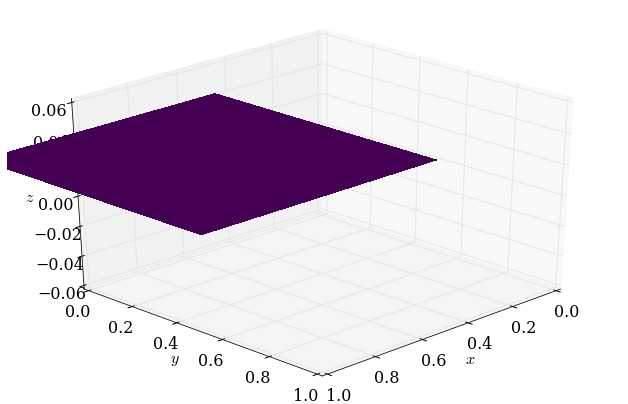

In [12]:
X, Y, x, y, p_i, b, dx, dy, L = poisson_IG(nx, ny, xmax, xmin, ymax, ymin)
plot_3D(x, y, p_i)

In [22]:
p, l2_conv = poisson_2d(p_i.copy(), b, dx, dy, l2_target)

Number of Jacobi iterations: 249


ValueError: shape mismatch: objects cannot be broadcast to a single shape

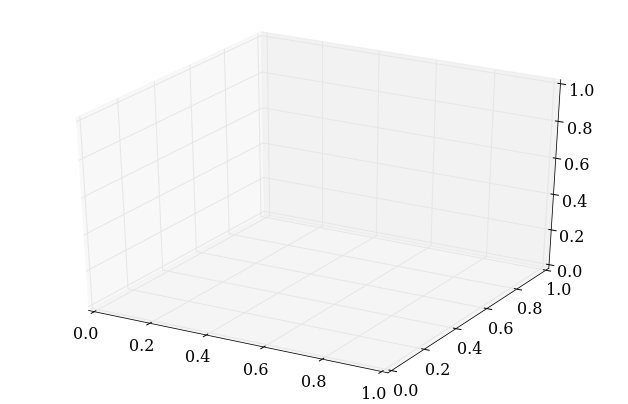

In [28]:
plot_3D(x,y,p)

In [15]:
def p_analytical(X,Y,L):
    ''' Computes analytical solution to Poisson problem
    Parameters:
    ----------
    X: 2D array of float
        Mesh with x components
    Y: 2D array of float
        Mesh with y components
    L: float
        Size of domain
    Returns:
    -------
    Analytical solution
    '''
    return numpy.sin(X*pi/L)*numpy.cos(Y*pi/L)

In [16]:
p_an = p_analytical(X,Y,L)

In [29]:
error = L2_rel_error(p,p_an)
error

ValueError: operands could not be broadcast together with shapes (11,11) (41,41) 

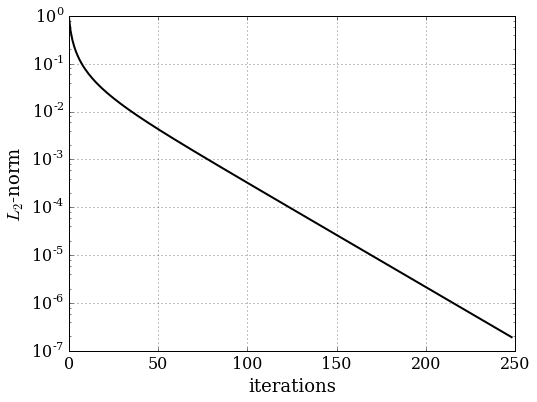

In [30]:
pyplot.figure(figsize=(8,6))
pyplot.grid(True)
pyplot.xlabel(r'iterations', fontsize=18)
pyplot.ylabel(r'$L_2$-norm', fontsize=18)
pyplot.semilogy(numpy.arange(len(l2_conv)), l2_conv, lw=2, color='k');

In [31]:
nx_values = [11,21,41,81]

error = numpy.zeros_like(nx_values, dtype=numpy.float)

for i, nx in enumerate(nx_values):
    
    ny = nx
    
    X, Y, c, y, p_i, b, dx, dy, L = poisson_IG(nx, ny, xmax, xmin, ymax, ymin)
    p, l2_conv = poisson_2d(p_i.copy(), b, dx, dy, l2_target)

    p_an = p_analytical(X,Y,L)
    
    error[i] = L2_rel_error(p,p_an)

Number of Jacobi iterations: 249
Number of Jacobi iterations: 892
Number of Jacobi iterations: 3125
Number of Jacobi iterations: 10708


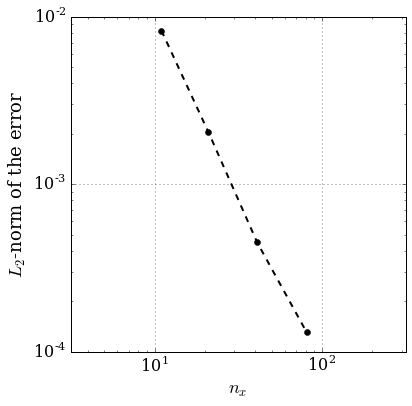

In [32]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
pyplot.loglog(nx_values, error, color='k', ls='--', lw=2, marker='o')
pyplot.axis('equal');